In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, recall_score, precision_score

In [17]:
cdf = pd.read_csv("cDMARD without URL with Vader polarity.csv")
bdf= pd.read_csv("bDMARD without URL with Vader polarity.csv")

neg_doc = list(cdf.tweet[cdf.fixed <-0.60]) + list(bdf.tweet[bdf.fixed <-0.60])
pos_doc = list(cdf.tweet[cdf.fixed>0.6]) + list(bdf.tweet[bdf.fixed>0.6])

EntireDocs = pos_doc + neg_doc
EntireLabels = [0 for _ in range(len(neg_doc))] + [1 for _ in range(len(pos_doc))]

from sklearn.utils import shuffle
EntireDocs, EntireLabels= shuffle(EntireDocs, EntireLabels)
X_train, X_test, y_train, y_test  = train_test_split(EntireDocs, EntireLabels, test_size=0.2, random_state=897)

In [15]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)


def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

In [30]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [17]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.8min finished


0.8490655689503088

In [18]:
grid_svm.best_params_

{'svc__C': 0.1}

In [19]:
grid_svm.best_score_

0.8269684055327102

In [24]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [21]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.8490538077036165,
 'f1': 0.8195402298850575,
 'acc': 0.7708029197080292,
 'precision': 0.8437869822485207,
 'recall': 0.7966480446927374}

In [25]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

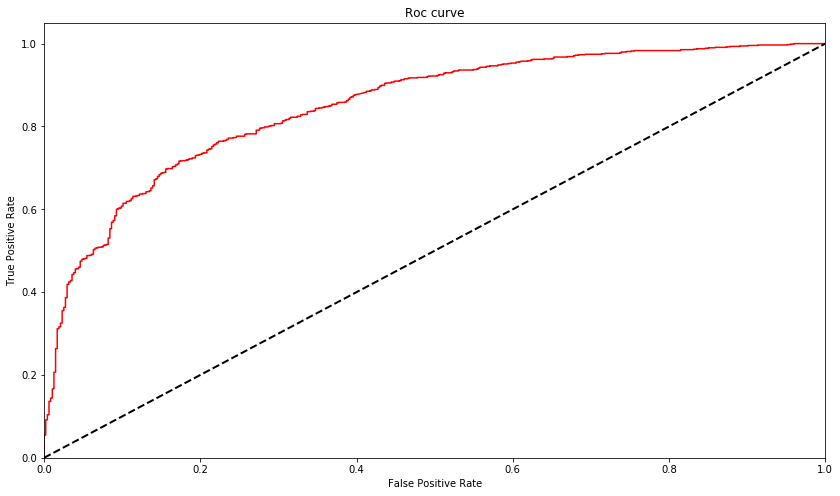

In [26]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [30]:
train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [26]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

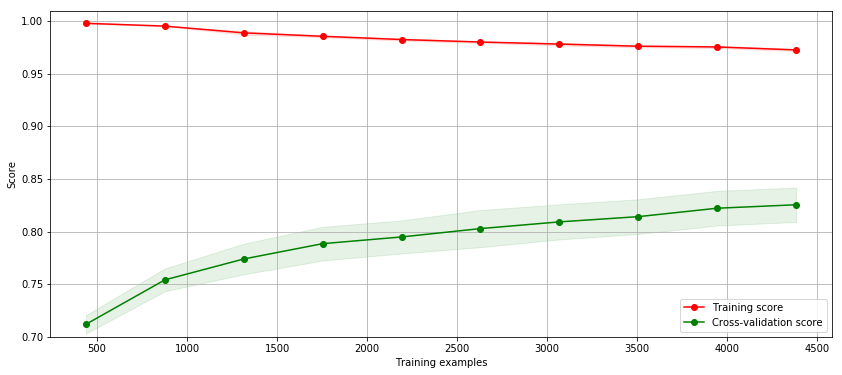

In [32]:
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

### Logistic Regression

In [37]:

grid_lr = GridSearchCV(pipeline_lr,
                    param_grid={'svc__C': [0.01, 0.1, 1]},  
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1) 

In [54]:
pipeline_lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'logisticregression', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregr

In [56]:
np.random.seed(1)

pipeline_lr = make_pipeline(vectorizer, 
                            LogisticRegression(verbose=1, solver='liblinear',random_state=0, penalty='l2',max_iter=1000))

grid_lr = GridSearchCV(pipeline_lr,
                    param_grid={'logisticregression__penalty': ['l1','l2'], 'logisticregression__C': [0.001,0.01,0.1,1,10,100,1000]}, 
                    scoring="roc_auc") 

grid_lr.fit(X_train, y_train)
grid_lr.score(X_test, y_test)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

0.8146706160529013

In [57]:
report_results(grid_lr.best_estimator_, X_test, y_test)

{'auc': 0.8146706160529013,
 'f1': 0.8165487207403376,
 'acc': 0.754014598540146,
 'precision': 0.7894736842105263,
 'recall': 0.8455467869222097}

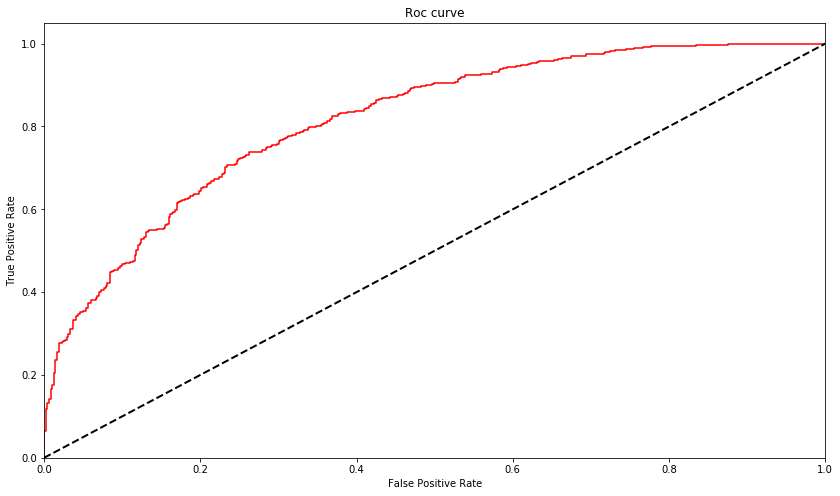

In [58]:
roc_lb = get_roc_curve(grid_lr.best_estimator_, X_test, y_test)

fpr, tpr = roc_lb
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

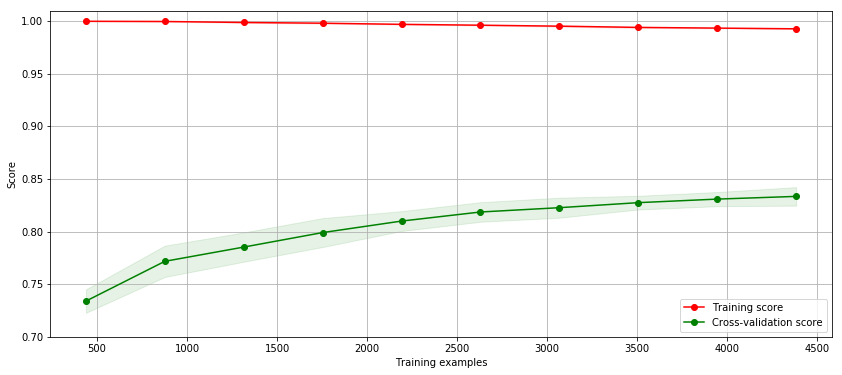

In [61]:
train_sizes, train_scores, test_scores = \
    learning_curve(grid_lr.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

### Naive Bayes 

In [31]:
np.random.seed(1)

pipeline_nb = make_pipeline(vectorizer, 
                            MultinomialNB())

grid_nb = GridSearchCV(pipeline_nb,
                    param_grid={}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1) 

grid_nb.fit(X_train, y_train)
grid_nb.score(X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.7846977622478823

In [32]:
report_results(grid_nb.best_estimator_, X_test, y_test)

{'auc': 0.7846977622478823,
 'f1': 0.8128286014721345,
 'acc': 0.7401459854014598,
 'precision': 0.761576354679803,
 'recall': 0.8714768883878241}

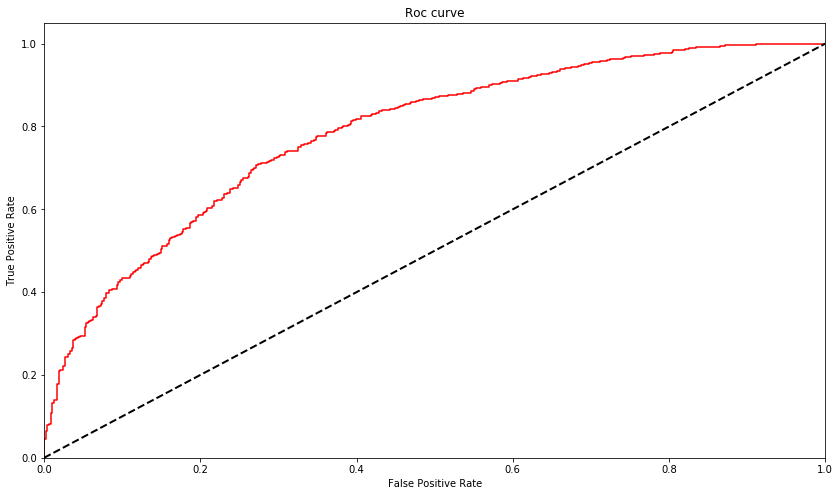

In [33]:
roc_svm = get_roc_curve(grid_nb.best_estimator_, X_test, y_test)

fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

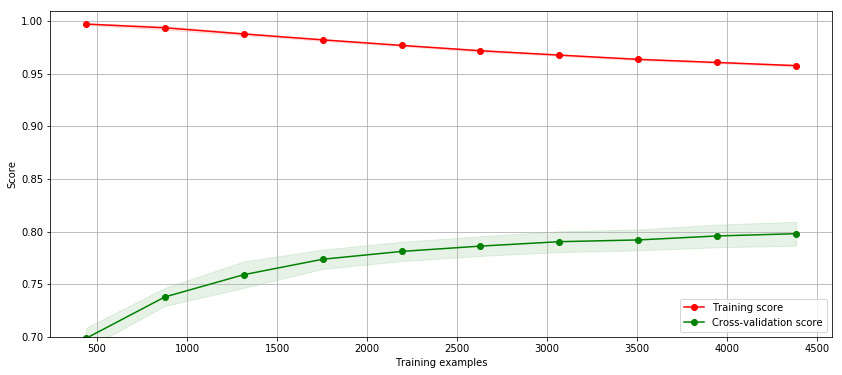

In [63]:
train_sizes, train_scores, test_scores = \
    learning_curve(grid_nb.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()